In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

#contour = load_contour().to(device)
#contour.shape

torch.Size([3, 386, 3, 64, 64])

In [2]:
T = 100
beta = torch.linspace(900e-4, 500e-4, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0007, device='cuda:0')

In [3]:
alpha_

tensor([9.1000e-01, 8.2847e-01, 7.5458e-01, 6.8758e-01, 6.2681e-01, 5.7166e-01,
        5.2160e-01, 4.7613e-01, 4.3482e-01, 3.9726e-01, 3.6312e-01, 3.3205e-01,
        3.0377e-01, 2.7803e-01, 2.5458e-01, 2.3321e-01, 2.1373e-01, 1.9596e-01,
        1.7975e-01, 1.6495e-01, 1.5144e-01, 1.3910e-01, 1.2781e-01, 1.1750e-01,
        1.0806e-01, 9.9428e-02, 9.1524e-02, 8.4285e-02, 7.7653e-02, 7.1574e-02,
        6.6000e-02, 6.0887e-02, 5.6194e-02, 5.1886e-02, 4.7929e-02, 4.4293e-02,
        4.0951e-02, 3.7878e-02, 3.5050e-02, 3.2448e-02, 3.0052e-02, 2.7845e-02,
        2.5812e-02, 2.3937e-02, 2.2208e-02, 2.0613e-02, 1.9141e-02, 1.7782e-02,
        1.6527e-02, 1.5366e-02, 1.4294e-02, 1.3302e-02, 1.2384e-02, 1.1535e-02,
        1.0748e-02, 1.0020e-02, 9.3448e-03, 8.7190e-03, 8.1386e-03, 7.6001e-03,
        7.1004e-03, 6.6363e-03, 6.2053e-03, 5.8048e-03, 5.4324e-03, 5.0862e-03,
        4.7641e-03, 4.4643e-03, 4.1851e-03, 3.9252e-03, 3.6829e-03, 3.4571e-03,
        3.2465e-03, 3.0501e-03, 2.8668e-

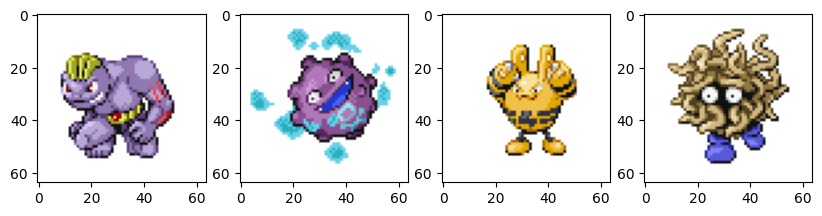

In [4]:
transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], 0.2),
    v2.RandomApply([v2.RandomChannelPermutation()], 0.2),
    v2.RandomGrayscale(p = 0.2),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [6]:
model = UNet(3, 3).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    N = 3

    x = torch.randn((N, 3, 64, 64), device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
    
    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|                                                                                                                                       | 0/100001 [00:00<?, ?it/s]

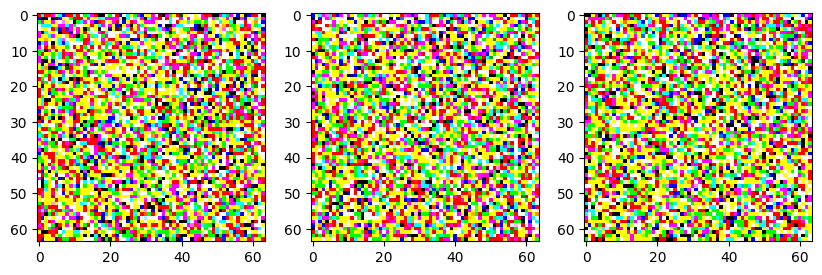

0.01574063:   1%|█                                                                                                              | 999/100001 [01:26<2:20:00, 11.79it/s]

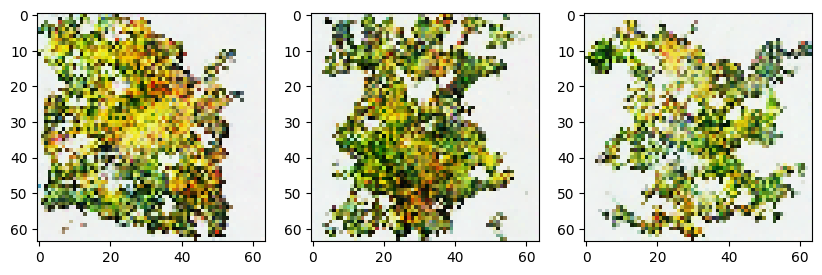

0.02090133:   2%|██▏                                                                                                           | 1999/100001 [02:52<2:18:39, 11.78it/s]

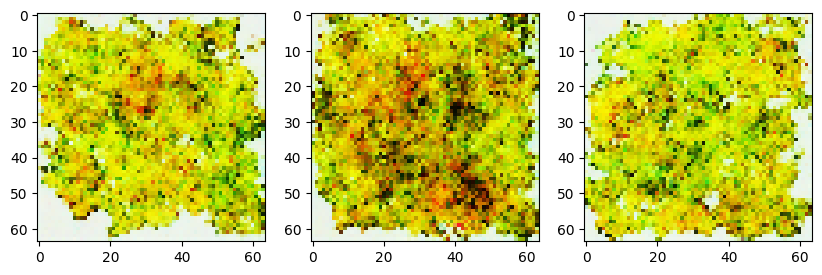

0.04909336:   3%|███▎                                                                                                          | 2999/100001 [04:18<2:17:07, 11.79it/s]

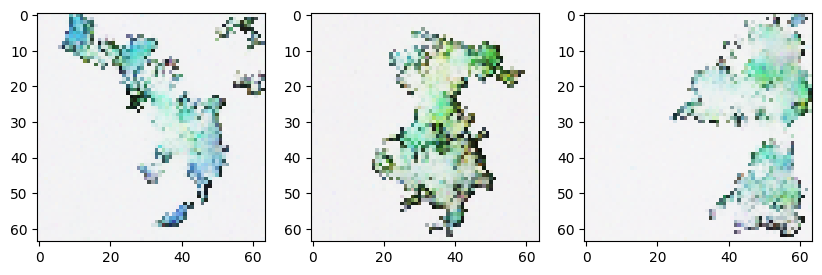

0.03564253:   4%|████▍                                                                                                         | 3999/100001 [05:44<2:15:37, 11.80it/s]

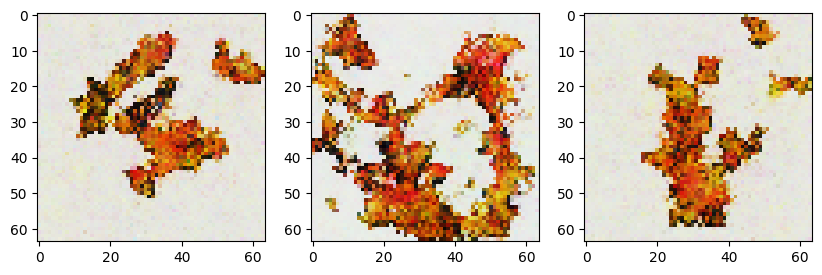

0.00851398:   5%|█████▍                                                                                                        | 4999/100001 [07:11<2:14:22, 11.78it/s]

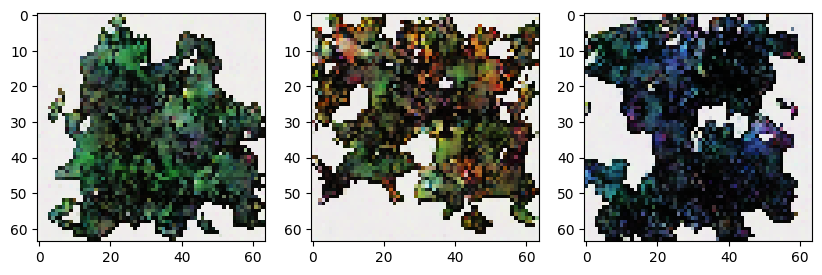

0.02104763:   6%|██████▌                                                                                                       | 5999/100001 [08:37<2:12:58, 11.78it/s]

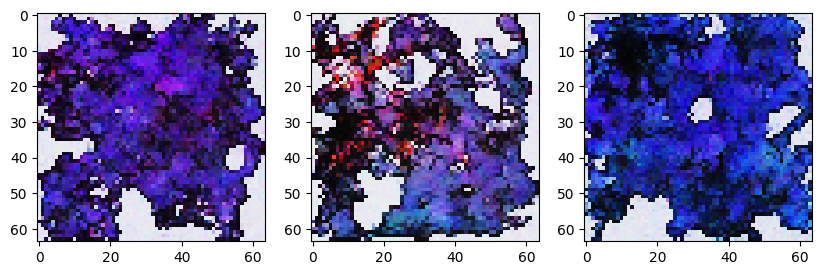

0.03969936:   7%|███████▋                                                                                                      | 6999/100001 [10:03<2:11:32, 11.78it/s]

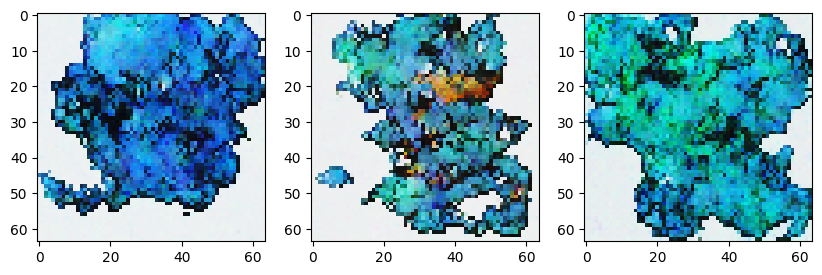

0.01637753:   8%|████████▊                                                                                                     | 7999/100001 [11:30<2:10:04, 11.79it/s]

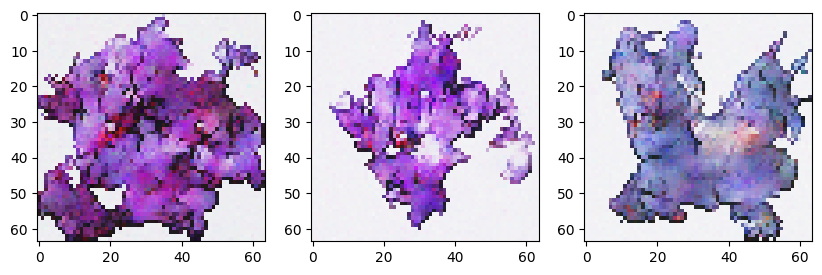

0.01312620:   9%|█████████▉                                                                                                    | 8999/100001 [12:56<2:08:43, 11.78it/s]

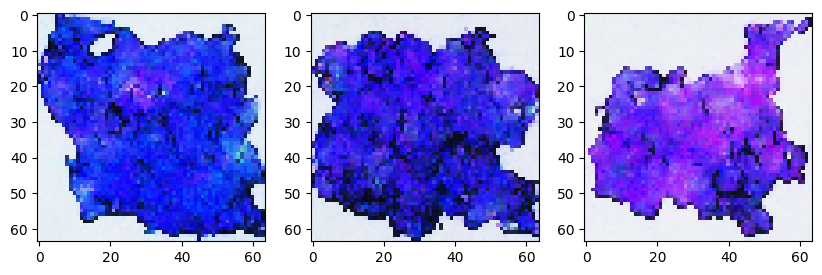

0.01957947:  10%|██████████▉                                                                                                   | 9999/100001 [14:22<2:07:25, 11.77it/s]

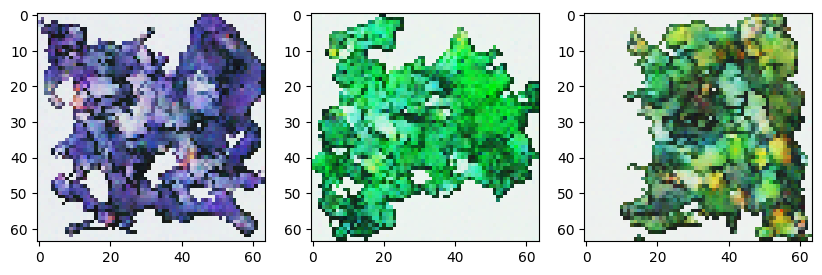

0.03202748:  11%|███████████▉                                                                                                 | 10999/100001 [15:49<2:05:51, 11.79it/s]

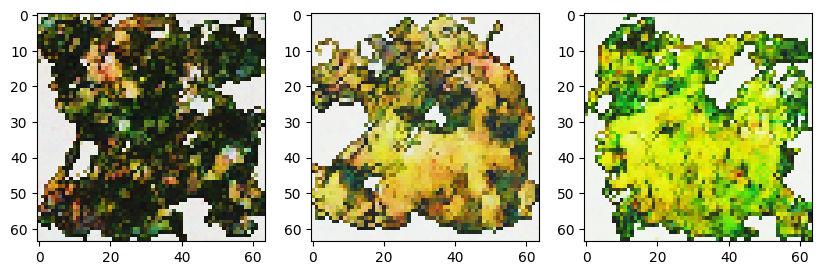

0.01643204:  12%|█████████████                                                                                                | 11999/100001 [17:15<2:04:27, 11.78it/s]

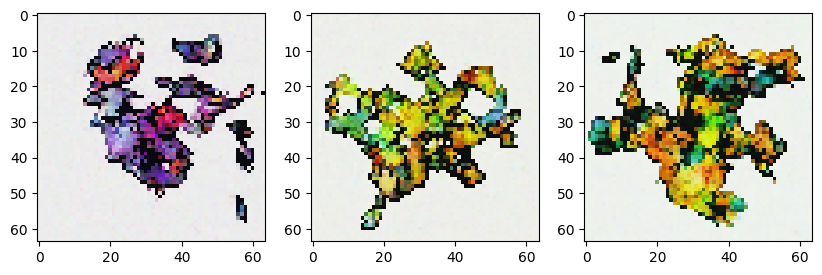

0.02583363:  13%|██████████████▏                                                                                              | 12999/100001 [18:41<2:03:11, 11.77it/s]

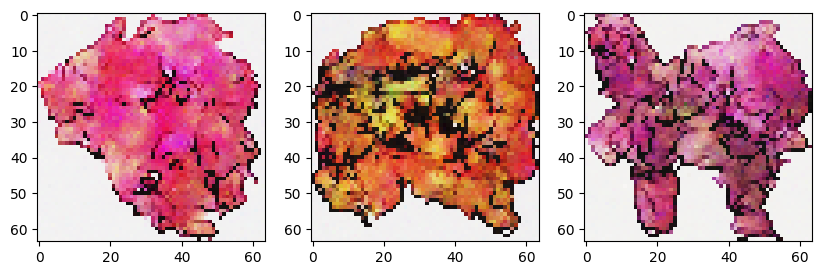

0.01259673:  14%|███████████████▎                                                                                             | 13999/100001 [20:08<2:01:42, 11.78it/s]

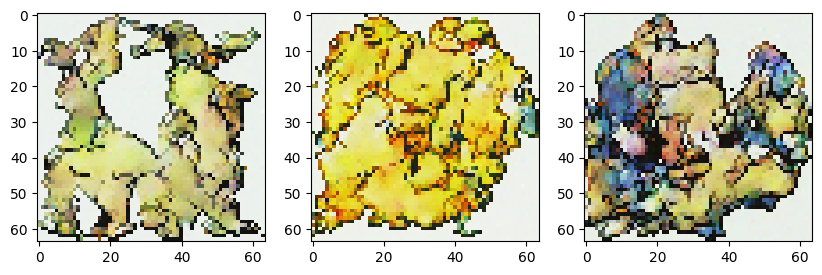

0.01392205:  15%|████████████████▎                                                                                            | 14999/100001 [21:34<2:00:10, 11.79it/s]

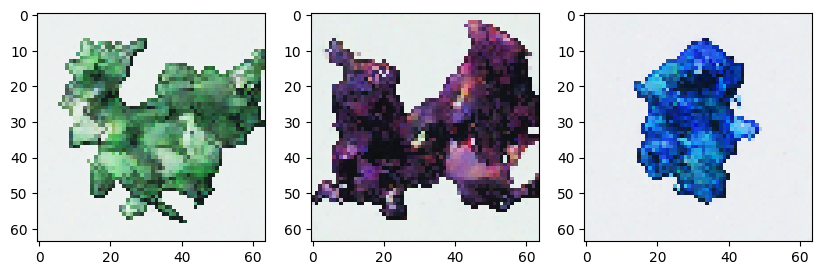

0.00918462:  16%|█████████████████▍                                                                                           | 15999/100001 [23:00<1:58:45, 11.79it/s]

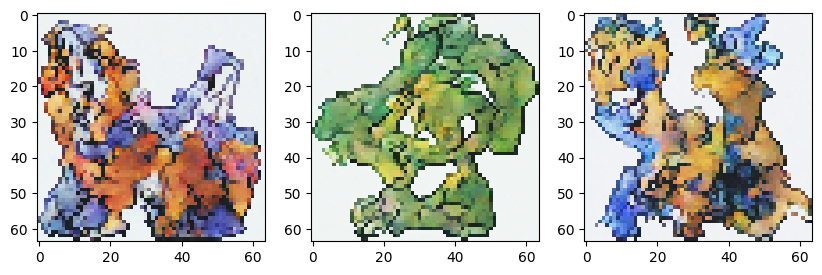

0.03407679:  17%|██████████████████▌                                                                                          | 16999/100001 [24:26<1:57:18, 11.79it/s]

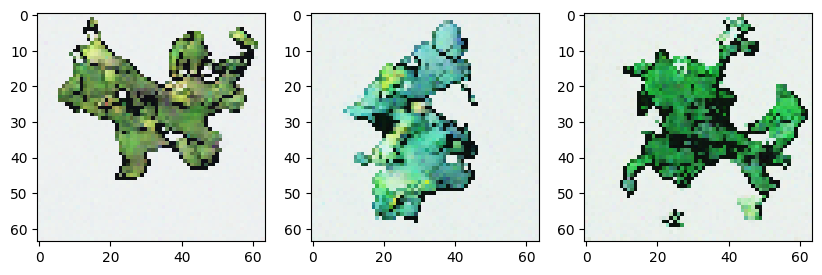

0.02308998:  18%|███████████████████▌                                                                                         | 17999/100001 [25:53<1:56:01, 11.78it/s]

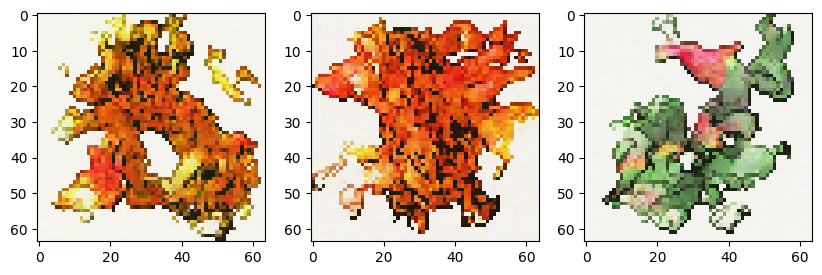

0.02844939:  19%|████████████████████▋                                                                                        | 18999/100001 [27:19<1:54:34, 11.78it/s]

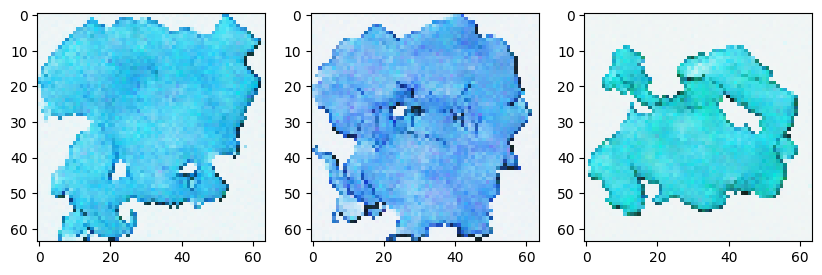

0.03135250:  20%|█████████████████████▊                                                                                       | 19999/100001 [28:45<1:53:13, 11.78it/s]

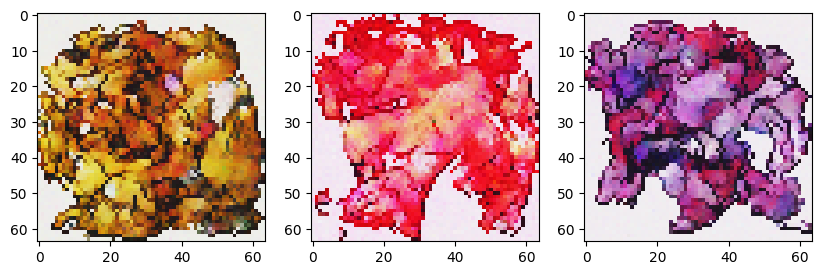

0.01377273:  21%|██████████████████████▉                                                                                      | 20999/100001 [30:12<1:51:44, 11.78it/s]

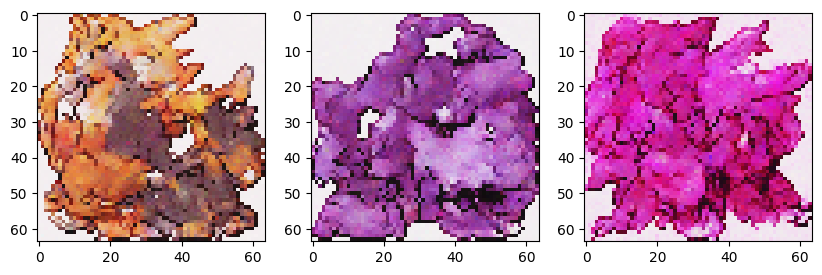

0.01655001:  22%|███████████████████████▉                                                                                     | 21999/100001 [31:38<1:50:22, 11.78it/s]

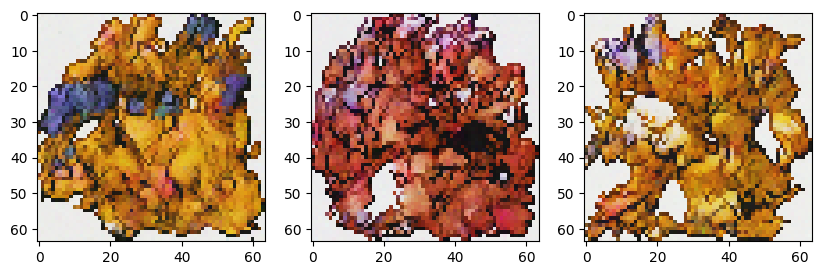

0.01251735:  23%|█████████████████████████                                                                                    | 22999/100001 [33:04<1:48:52, 11.79it/s]

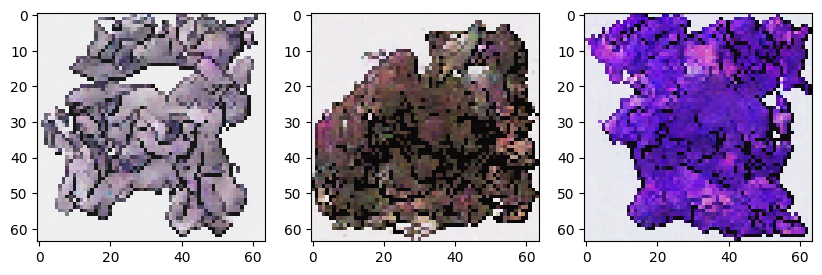

0.00919358:  24%|██████████████████████████▏                                                                                  | 23999/100001 [34:31<1:47:41, 11.76it/s]

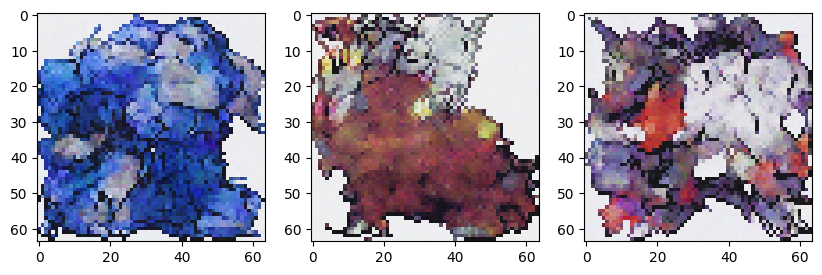

0.03342047:  25%|███████████████████████████▏                                                                                 | 24999/100001 [35:57<1:46:03, 11.79it/s]

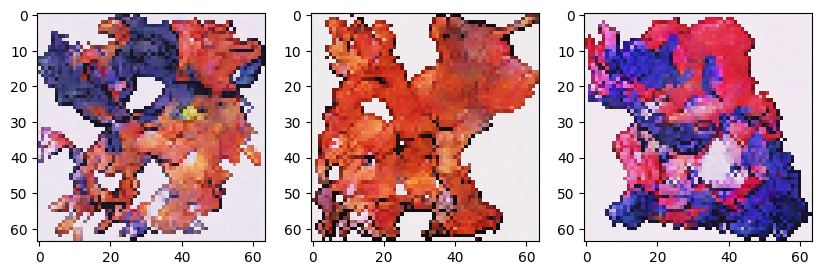

0.01698199:  26%|████████████████████████████▎                                                                                | 25999/100001 [37:23<1:44:43, 11.78it/s]

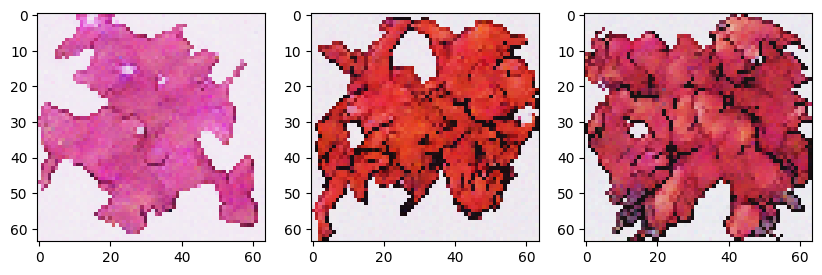

0.04067335:  27%|█████████████████████████████▍                                                                               | 26999/100001 [38:50<1:43:10, 11.79it/s]

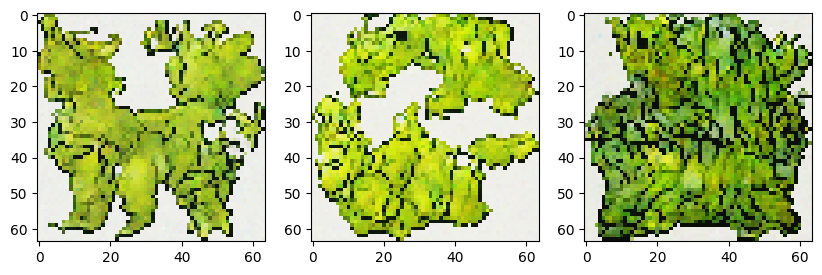

0.03231708:  28%|██████████████████████████████▌                                                                              | 27999/100001 [40:16<1:41:44, 11.79it/s]

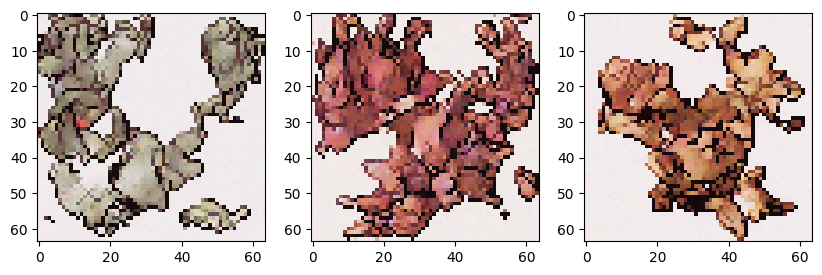

0.02529033:  29%|███████████████████████████████▌                                                                             | 28999/100001 [41:42<1:40:25, 11.78it/s]

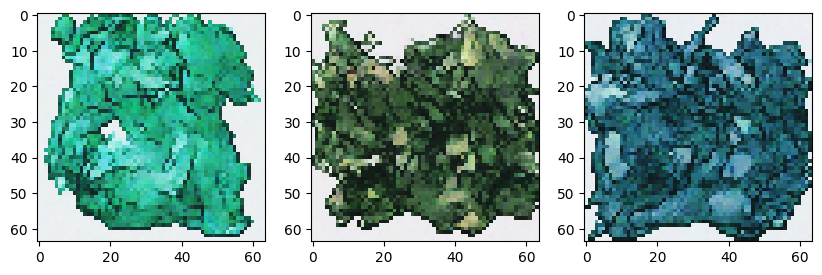

0.01652219:  30%|████████████████████████████████▋                                                                            | 29999/100001 [43:08<1:38:52, 11.80it/s]

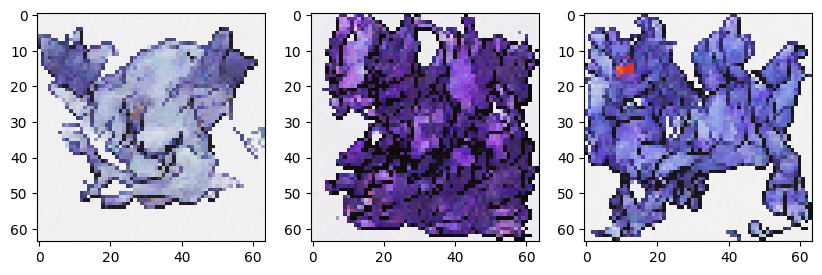

0.01495094:  31%|█████████████████████████████████▊                                                                           | 30999/100001 [44:35<1:37:32, 11.79it/s]

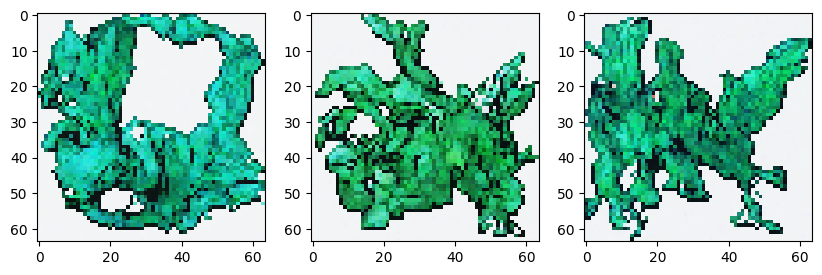

0.01266846:  32%|██████████████████████████████████▉                                                                          | 31999/100001 [46:01<1:36:04, 11.80it/s]

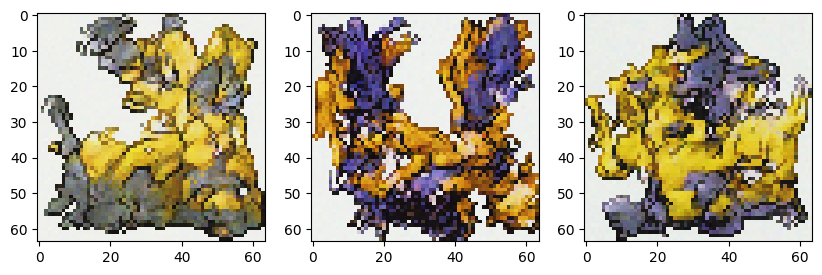

0.01553918:  33%|███████████████████████████████████▉                                                                         | 32999/100001 [47:27<1:34:35, 11.81it/s]

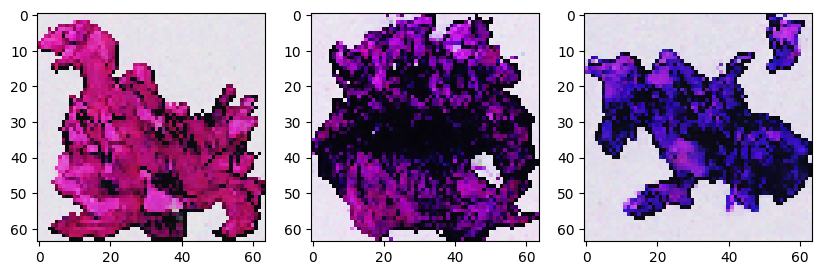

0.01307918:  34%|█████████████████████████████████████                                                                        | 33999/100001 [48:53<1:33:13, 11.80it/s]

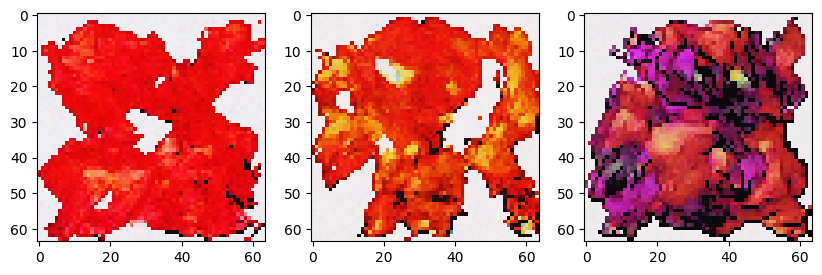

0.02868420:  35%|██████████████████████████████████████▏                                                                      | 34999/100001 [50:20<1:31:47, 11.80it/s]

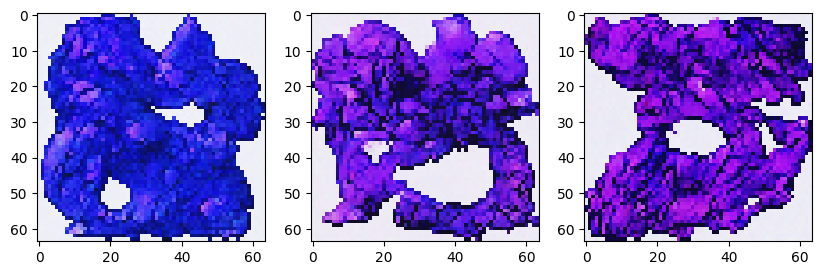

0.02726902:  36%|███████████████████████████████████████▏                                                                     | 35999/100001 [51:46<1:30:26, 11.79it/s]

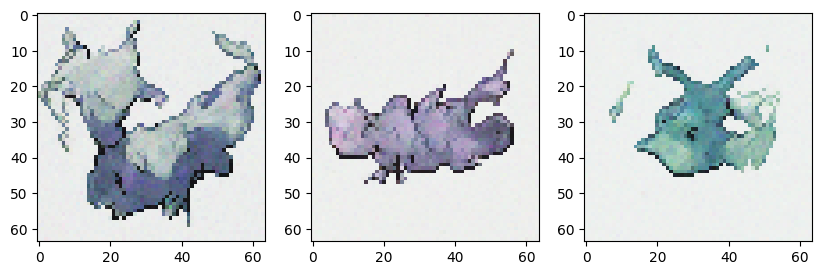

0.01304300:  37%|████████████████████████████████████████▎                                                                    | 36999/100001 [53:12<1:29:05, 11.79it/s]

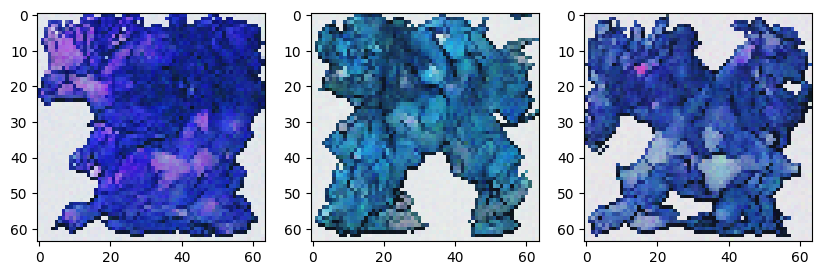

0.02345959:  38%|█████████████████████████████████████████▍                                                                   | 37999/100001 [54:39<1:27:49, 11.77it/s]

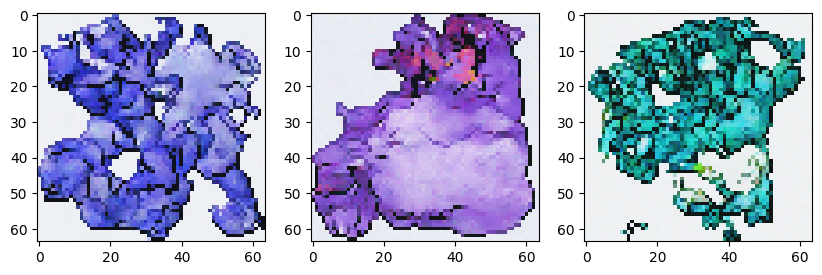

0.02293425:  39%|██████████████████████████████████████████▌                                                                  | 38999/100001 [56:05<1:27:28, 11.62it/s]

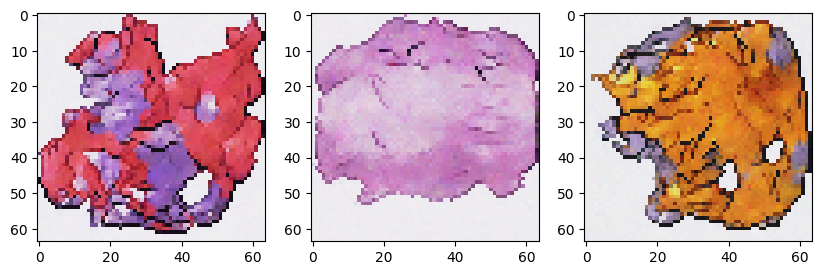

0.01062561:  40%|███████████████████████████████████████████▌                                                                 | 39999/100001 [57:31<1:24:53, 11.78it/s]

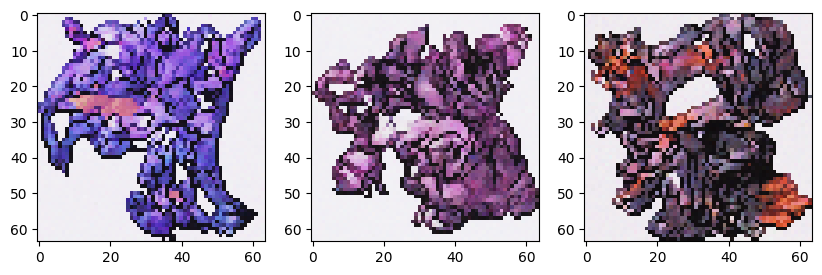

0.03251337:  41%|████████████████████████████████████████████▋                                                                | 40999/100001 [58:58<1:23:27, 11.78it/s]

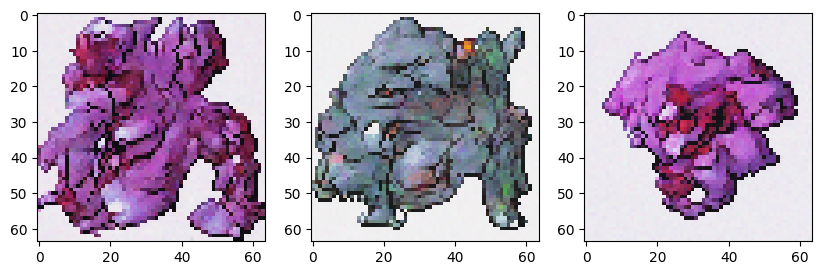

0.02600008:  42%|████████████████████████████████████████████▉                                                              | 41999/100001 [1:00:24<1:22:01, 11.79it/s]

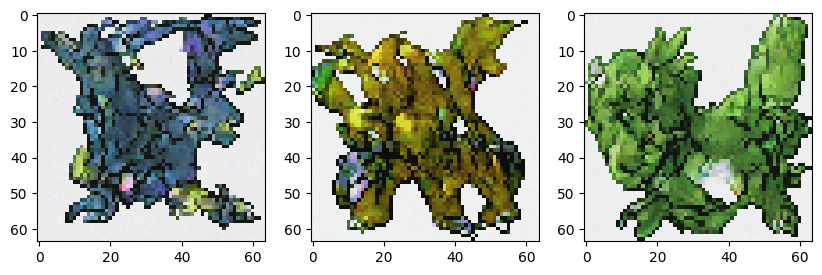

0.01602023:  43%|██████████████████████████████████████████████                                                             | 42999/100001 [1:01:50<1:20:42, 11.77it/s]

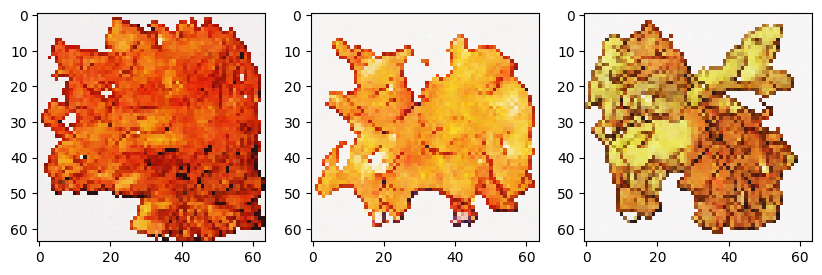

0.01105789:  44%|███████████████████████████████████████████████                                                            | 43999/100001 [1:03:17<1:19:16, 11.77it/s]

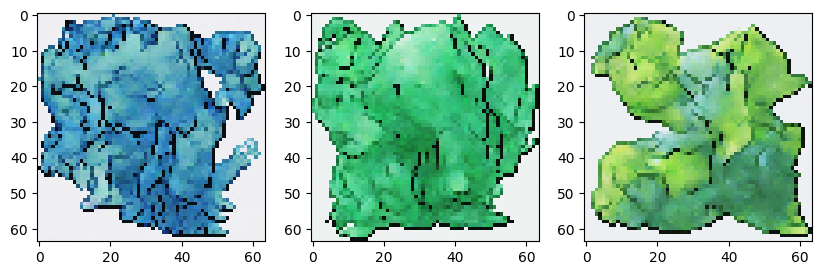

0.01786942:  45%|████████████████████████████████████████████████▏                                                          | 44999/100001 [1:04:43<1:17:57, 11.76it/s]

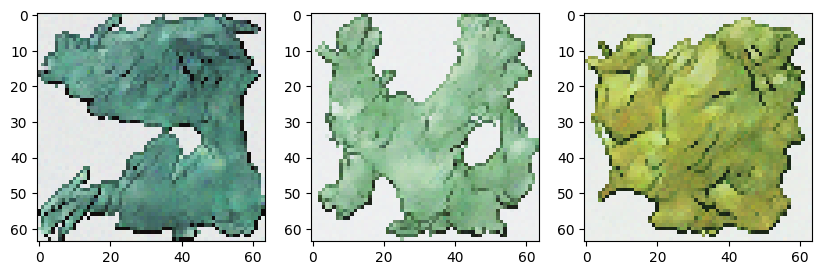

0.00899280:  46%|█████████████████████████████████████████████████▏                                                         | 45999/100001 [1:06:09<1:16:27, 11.77it/s]

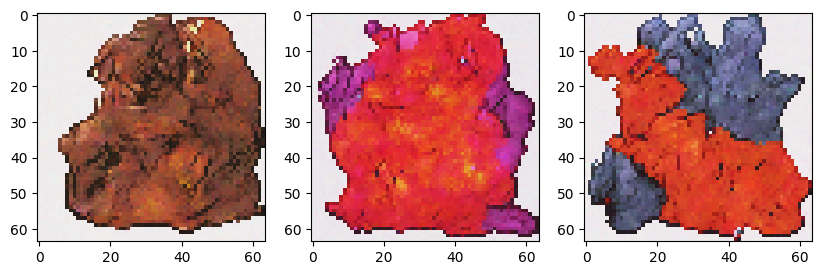

0.01782327:  47%|██████████████████████████████████████████████████▎                                                        | 46999/100001 [1:07:36<1:15:05, 11.76it/s]

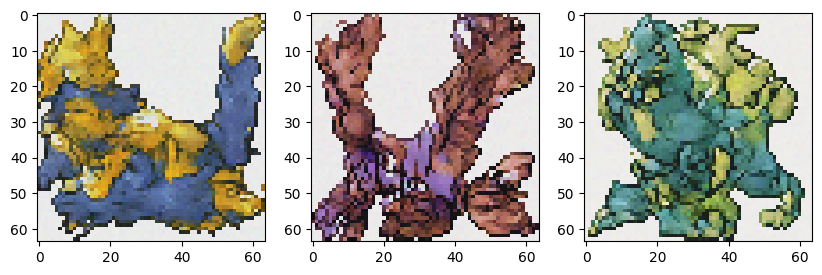

0.00763515:  48%|███████████████████████████████████████████████████▎                                                       | 47999/100001 [1:09:02<1:13:39, 11.77it/s]

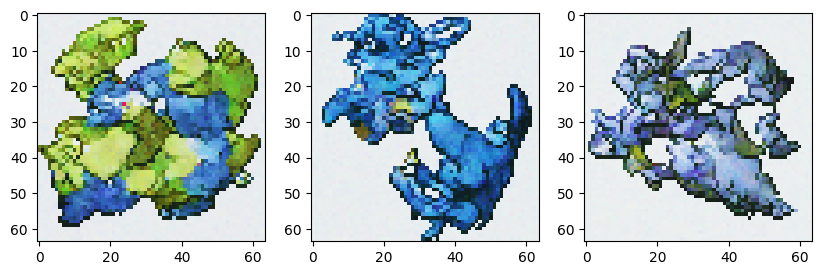

0.01150497:  49%|████████████████████████████████████████████████████▍                                                      | 48999/100001 [1:10:28<1:12:11, 11.77it/s]

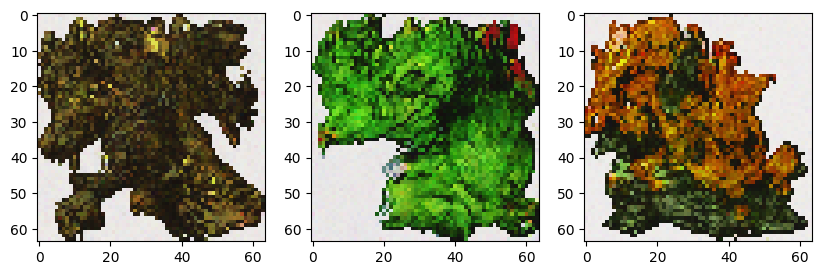

0.01604415:  50%|█████████████████████████████████████████████████████▍                                                     | 49999/100001 [1:11:55<1:10:43, 11.78it/s]

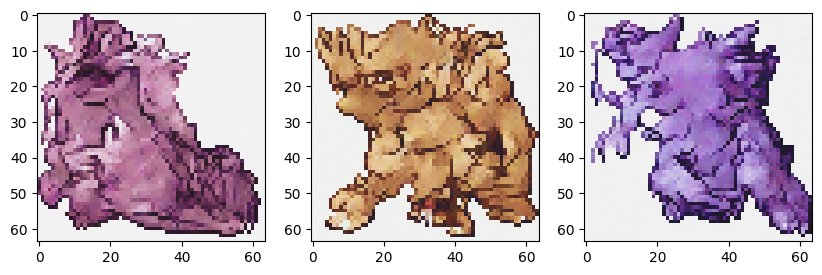

0.02308537:  51%|██████████████████████████████████████████████████████▌                                                    | 50999/100001 [1:13:21<1:09:17, 11.79it/s]

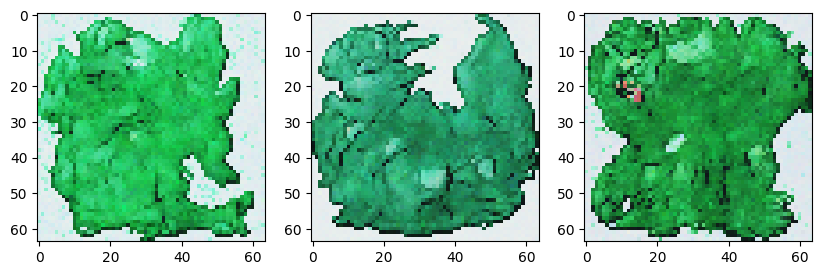

0.02128967:  52%|███████████████████████████████████████████████████████▋                                                   | 51999/100001 [1:14:48<1:07:57, 11.77it/s]

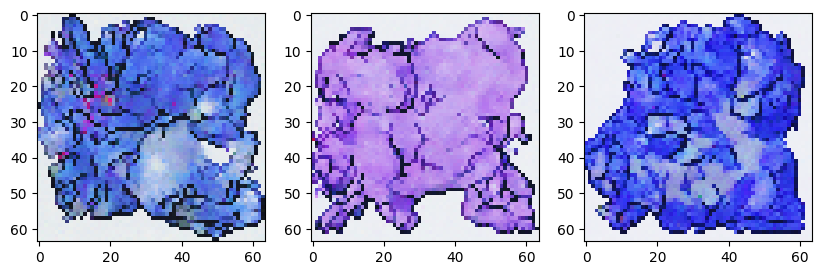

0.00866253:  53%|████████████████████████████████████████████████████████▋                                                  | 52999/100001 [1:16:14<1:06:27, 11.79it/s]

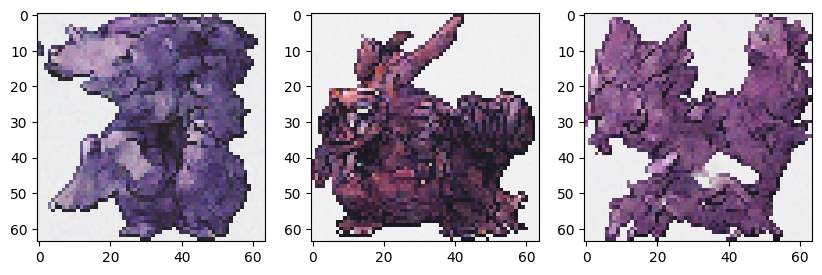

0.01127143:  54%|█████████████████████████████████████████████████████████▊                                                 | 53999/100001 [1:17:40<1:04:58, 11.80it/s]

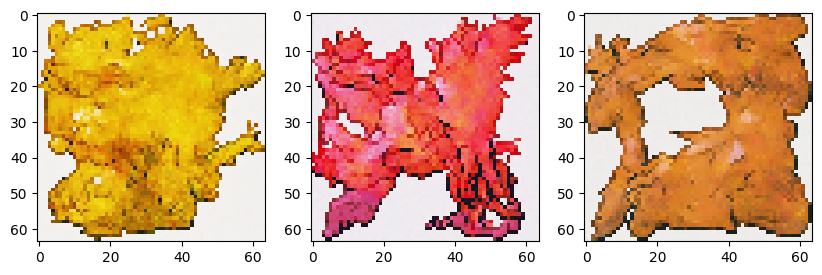

0.02310634:  55%|██████████████████████████████████████████████████████████▊                                                | 54999/100001 [1:19:07<1:03:43, 11.77it/s]

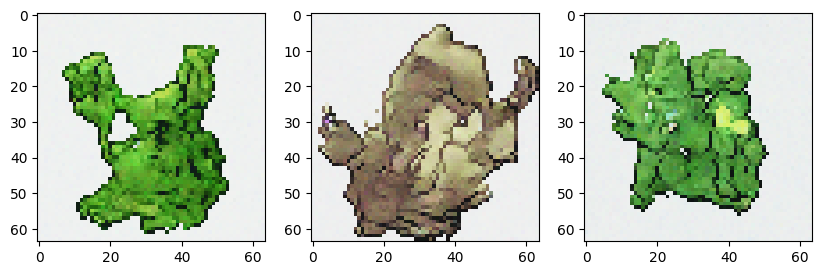

0.02951964:  56%|███████████████████████████████████████████████████████████▉                                               | 55999/100001 [1:20:33<1:02:09, 11.80it/s]

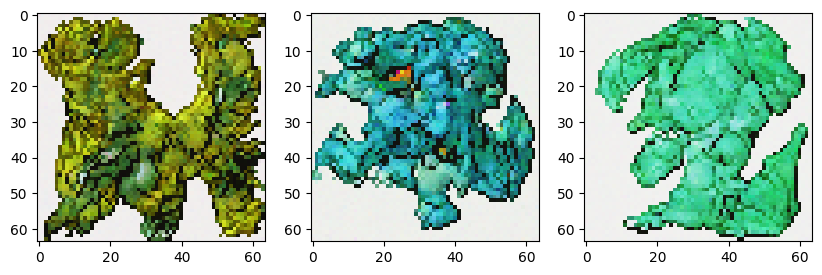

0.02733820:  57%|████████████████████████████████████████████████████████████▉                                              | 56999/100001 [1:21:59<1:00:55, 11.77it/s]

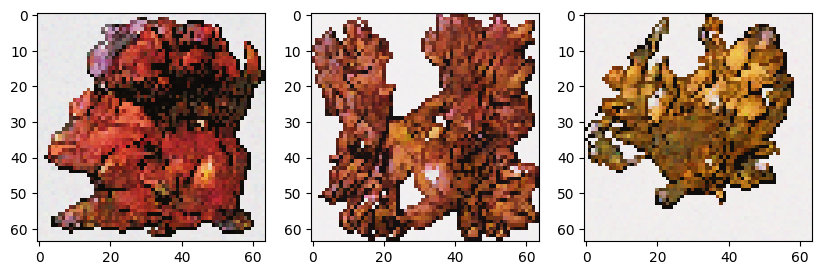

0.02667726:  58%|███████████████████████████████████████████████████████████████▏                                             | 57999/100001 [1:23:26<59:25, 11.78it/s]

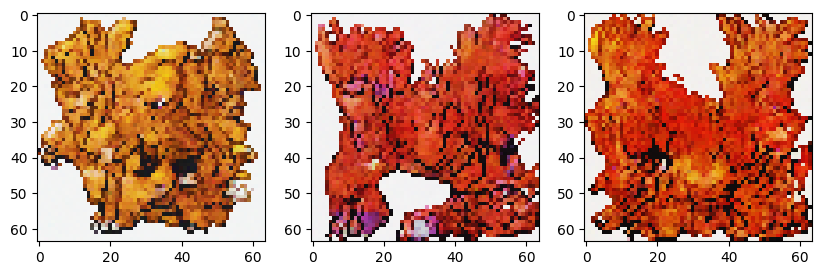

0.01240945:  59%|████████████████████████████████████████████████████████████████▎                                            | 58999/100001 [1:24:52<58:00, 11.78it/s]

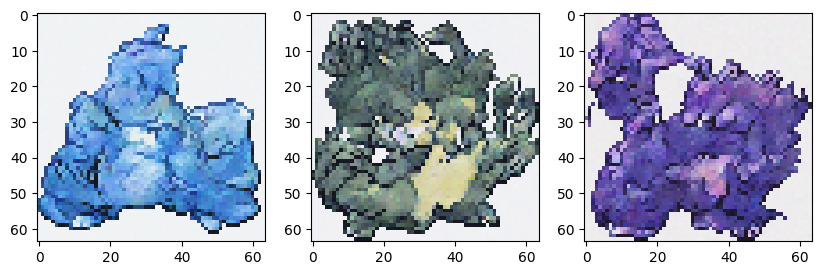

0.01897479:  60%|█████████████████████████████████████████████████████████████████▍                                           | 59999/100001 [1:26:18<56:36, 11.78it/s]

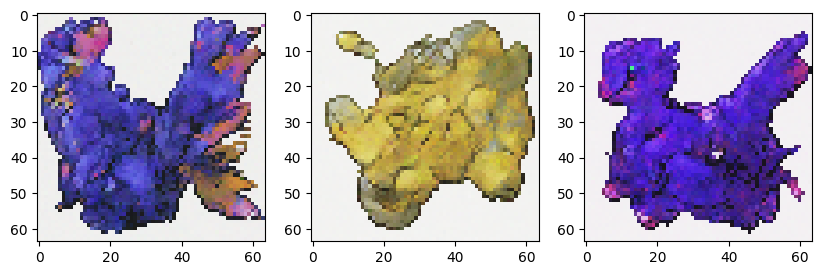

0.01655908:  61%|██████████████████████████████████████████████████████████████████▍                                          | 60999/100001 [1:27:45<55:14, 11.77it/s]

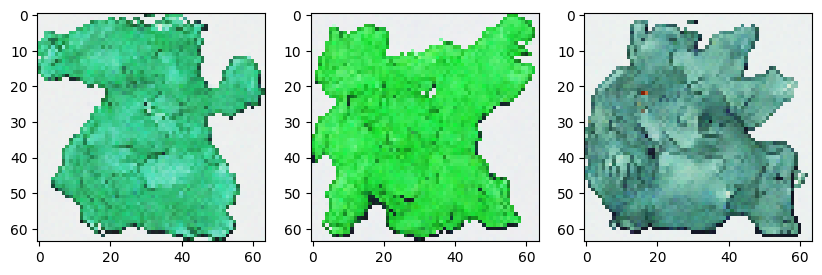

0.01723474:  62%|███████████████████████████████████████████████████████████████████▌                                         | 61999/100001 [1:29:11<53:48, 11.77it/s]

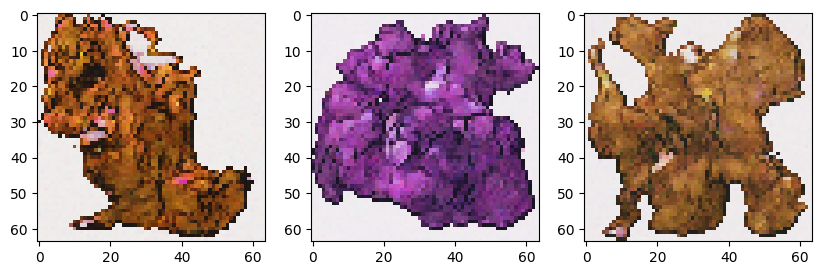

0.02649265:  63%|████████████████████████████████████████████████████████████████████▋                                        | 62999/100001 [1:30:37<52:18, 11.79it/s]

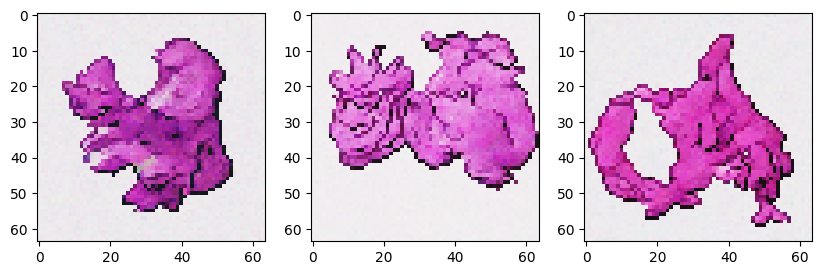

0.01922706:  64%|█████████████████████████████████████████████████████████████████████▊                                       | 63999/100001 [1:32:04<50:55, 11.78it/s]

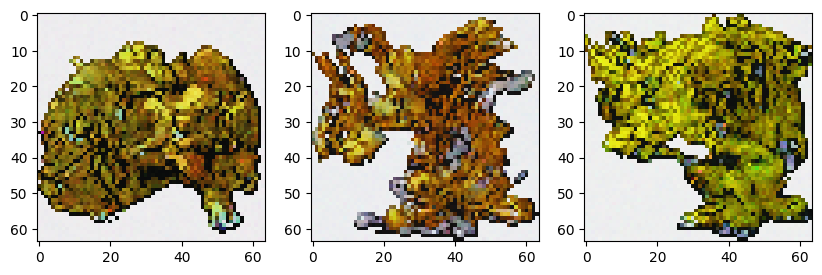

0.01438107:  65%|██████████████████████████████████████████████████████████████████████▊                                      | 64999/100001 [1:33:30<49:30, 11.78it/s]

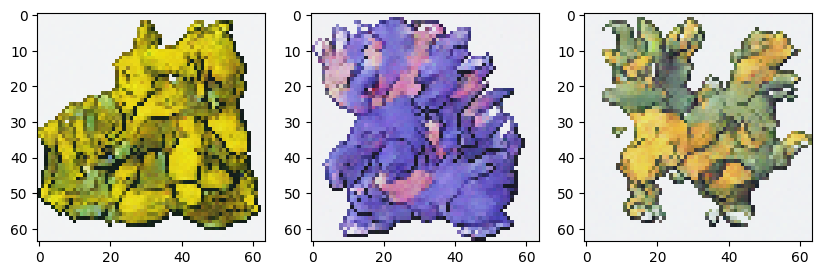

0.02115939:  66%|███████████████████████████████████████████████████████████████████████▉                                     | 65999/100001 [1:34:56<48:06, 11.78it/s]

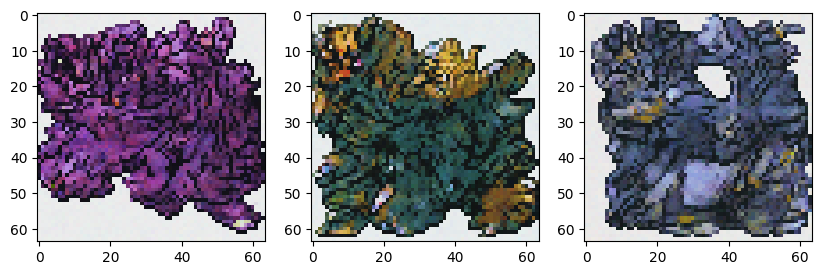

0.01978872:  67%|█████████████████████████████████████████████████████████████████████████                                    | 66999/100001 [1:36:23<46:37, 11.80it/s]

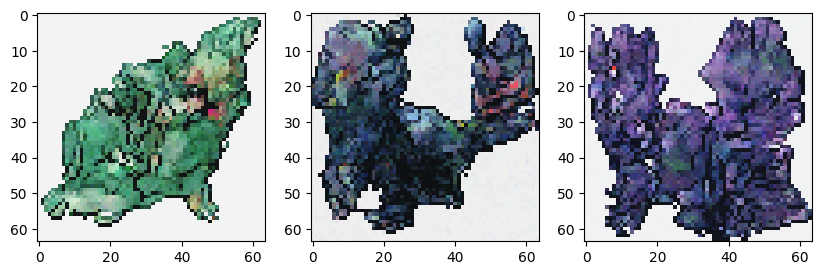

0.01764829:  68%|██████████████████████████████████████████████████████████████████████████                                   | 67999/100001 [1:37:49<45:14, 11.79it/s]

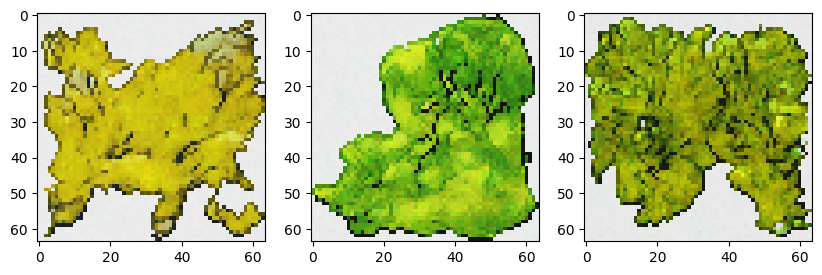

0.02442927:  69%|███████████████████████████████████████████████████████████████████████████▏                                 | 68999/100001 [1:39:15<43:50, 11.79it/s]

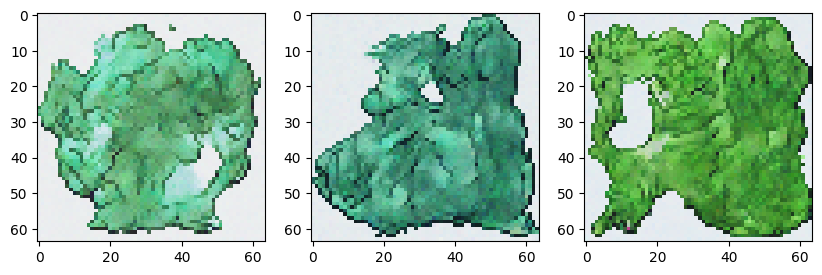

0.00818206:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 69999/100001 [1:40:42<42:24, 11.79it/s]

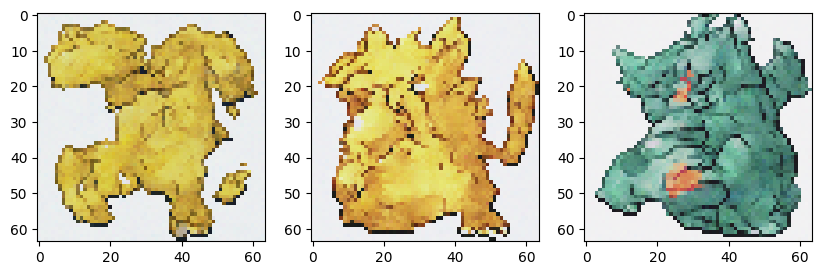

0.00924632:  71%|█████████████████████████████████████████████████████████████████████████████▍                               | 70999/100001 [1:42:08<41:03, 11.78it/s]

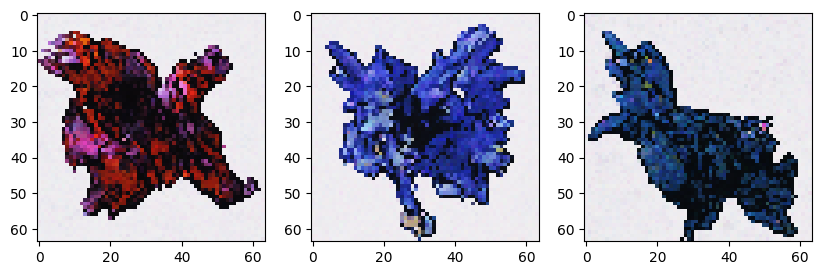

0.00686392:  72%|██████████████████████████████████████████████████████████████████████████████▍                              | 71999/100001 [1:43:34<39:36, 11.78it/s]

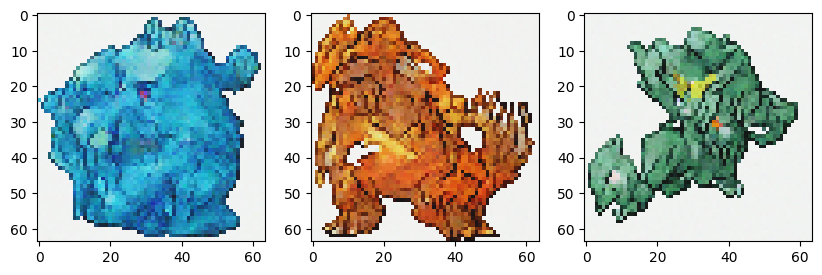

0.02040132:  73%|███████████████████████████████████████████████████████████████████████████████▌                             | 72999/100001 [1:45:01<38:12, 11.78it/s]

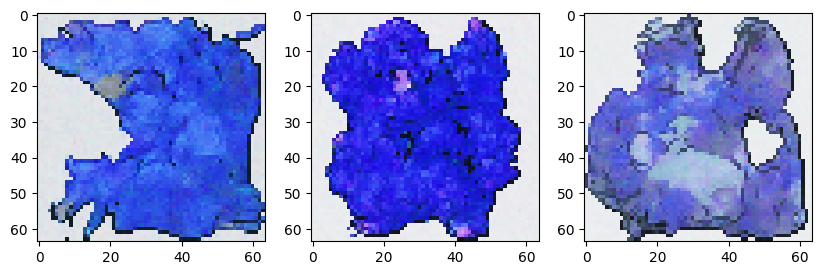

0.01879456:  74%|████████████████████████████████████████████████████████████████████████████████▋                            | 73999/100001 [1:46:27<36:51, 11.76it/s]

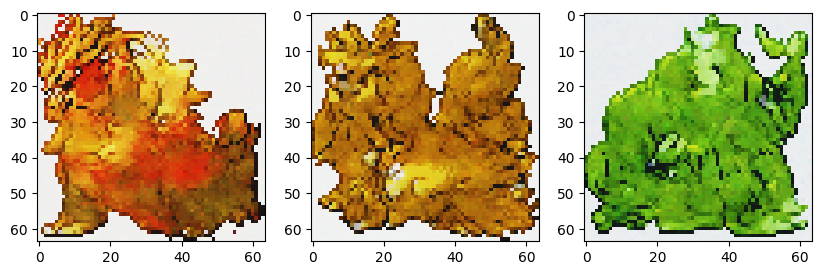

0.01281257:  75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 74999/100001 [1:47:53<35:23, 11.77it/s]

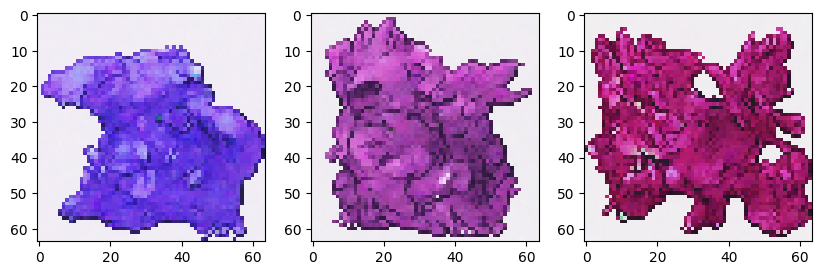

0.00996647:  76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 75999/100001 [1:49:20<33:57, 11.78it/s]

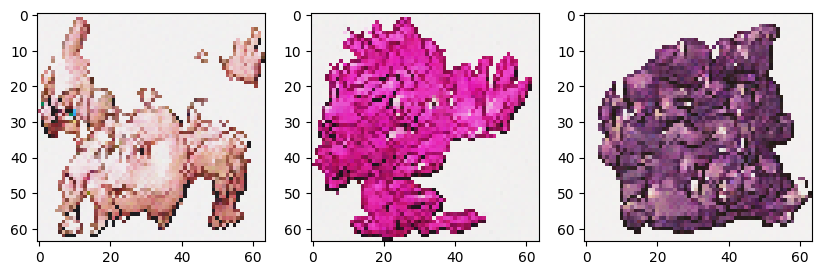

0.02235758:  77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 76999/100001 [1:50:46<32:32, 11.78it/s]

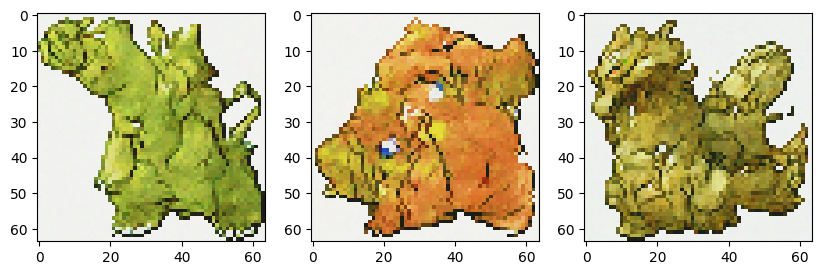

0.01898408:  78%|█████████████████████████████████████████████████████████████████████████████████████                        | 77999/100001 [1:52:13<31:10, 11.76it/s]

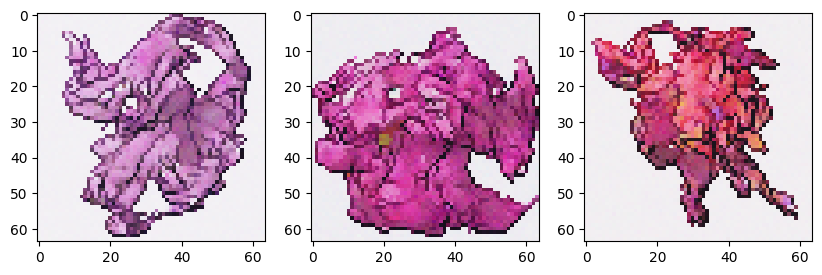

0.01772141:  79%|██████████████████████████████████████████████████████████████████████████████████████                       | 78999/100001 [1:53:39<29:42, 11.78it/s]

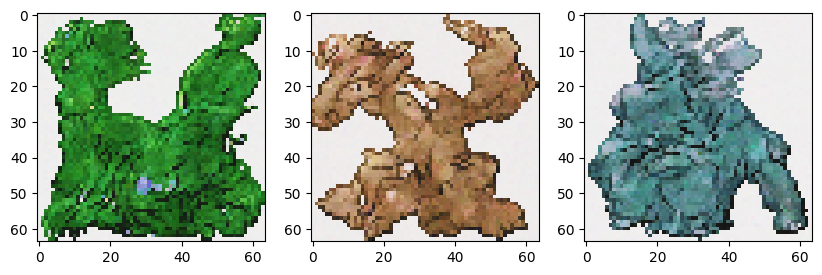

0.00900699:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 79999/100001 [1:55:05<28:20, 11.77it/s]

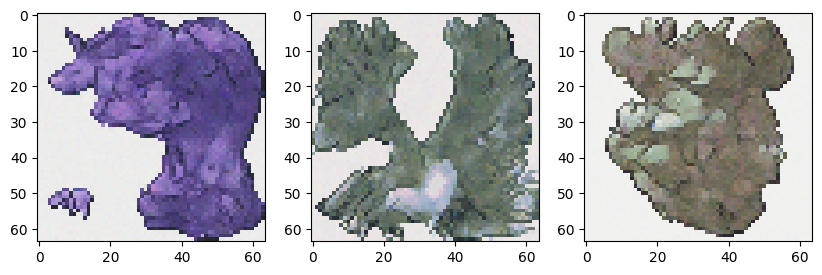

0.01996046:  81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 80999/100001 [1:56:32<26:50, 11.80it/s]

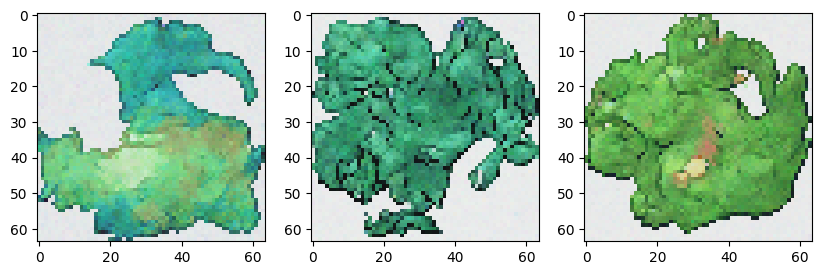

0.00959863:  82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 81999/100001 [1:57:58<25:26, 11.79it/s]

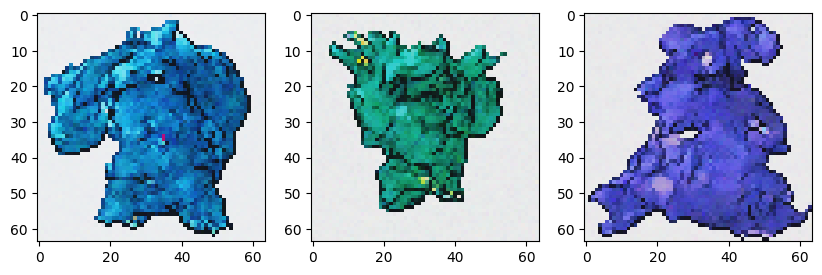

0.01881649:  83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 82999/100001 [1:59:24<24:00, 11.80it/s]

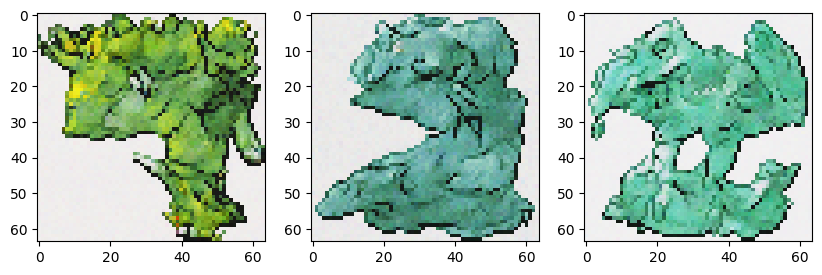

0.02271492:  84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 83999/100001 [2:00:50<22:39, 11.77it/s]

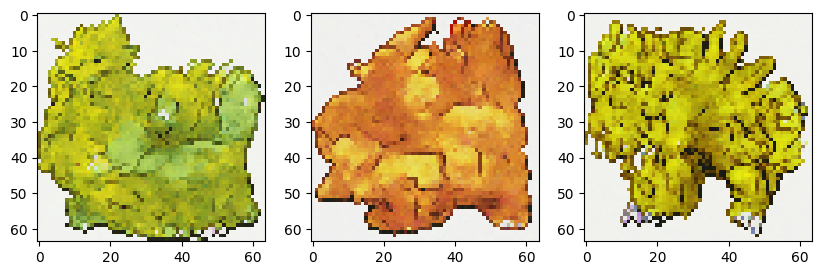

0.01602281:  85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 84999/100001 [2:02:17<21:13, 11.78it/s]

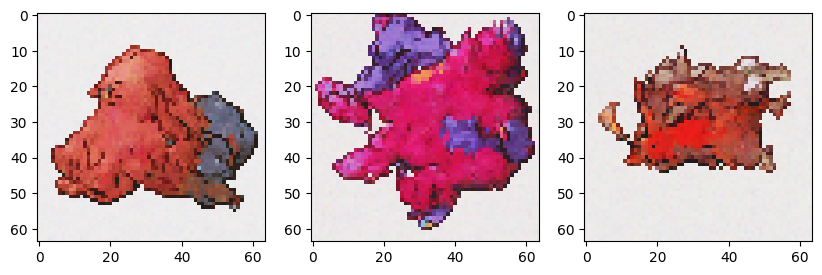

0.01548890:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 85999/100001 [2:03:43<19:49, 11.77it/s]

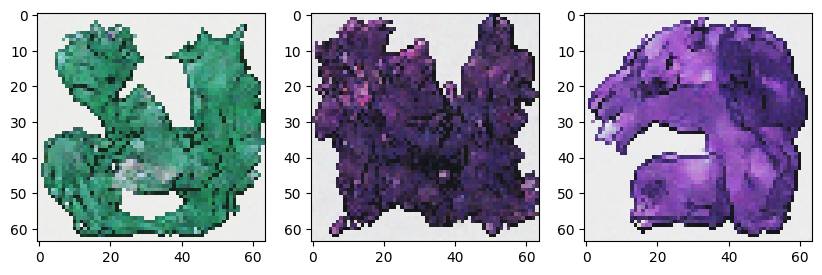

0.00981443:  87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 86999/100001 [2:05:09<18:21, 11.80it/s]

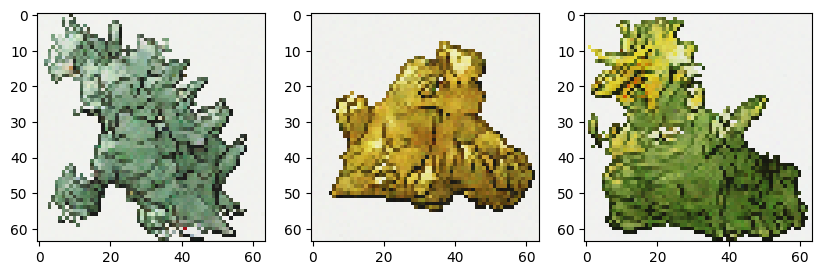

0.01226066:  88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 87999/100001 [2:06:36<16:57, 11.79it/s]

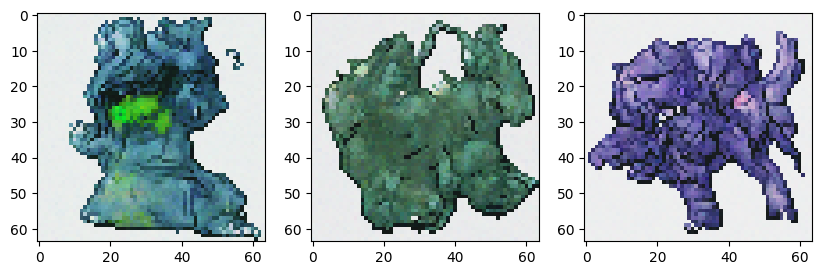

0.01097859:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 88999/100001 [2:08:02<15:33, 11.79it/s]

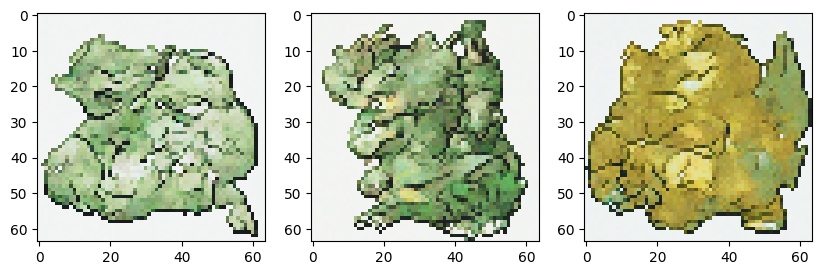

0.00967432:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 89999/100001 [2:09:28<14:09, 11.77it/s]

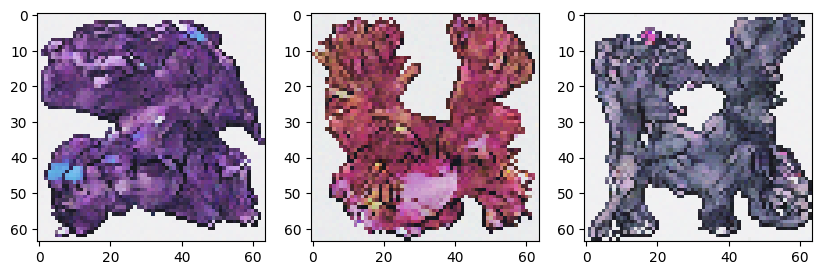

0.01683304:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 90999/100001 [2:10:55<12:43, 11.79it/s]

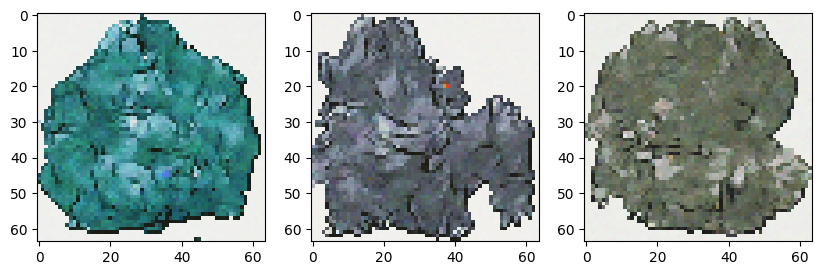

0.00824657:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 91999/100001 [2:12:21<11:19, 11.77it/s]

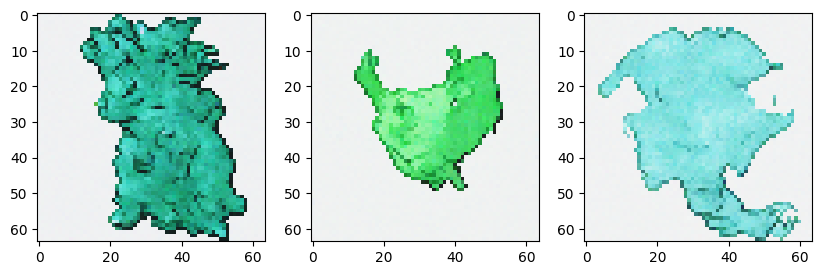

0.00998046:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 92999/100001 [2:13:47<09:53, 11.80it/s]

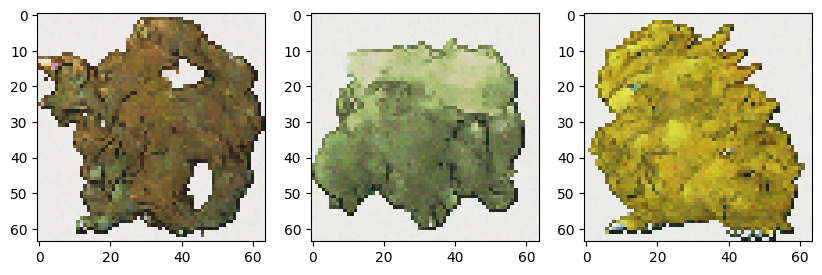

0.00522466:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 93999/100001 [2:15:13<08:29, 11.78it/s]

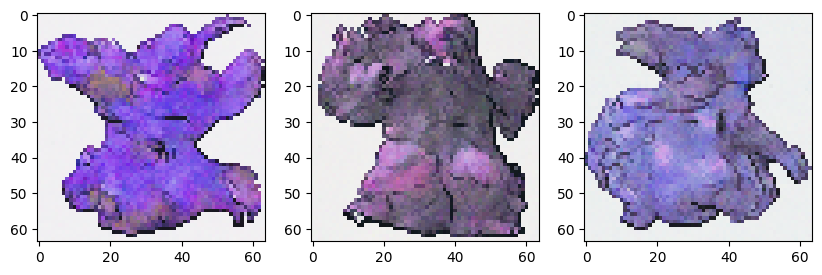

0.00829994:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 94999/100001 [2:16:40<07:04, 11.79it/s]

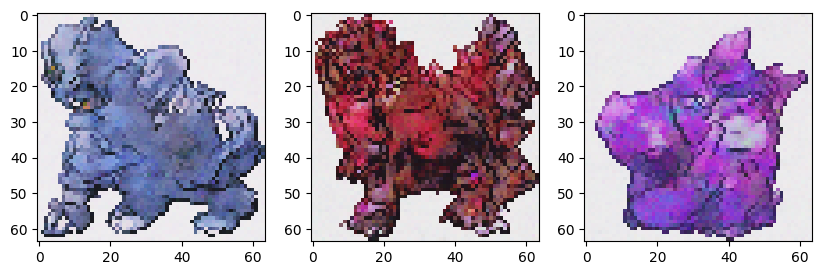

0.01150647:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 95999/100001 [2:18:06<05:39, 11.77it/s]

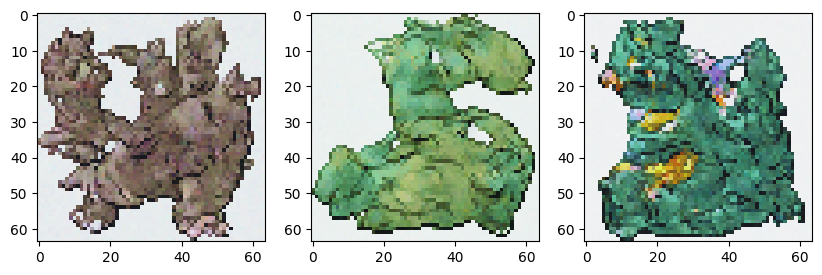

0.01753487:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 96999/100001 [2:19:32<04:14, 11.77it/s]

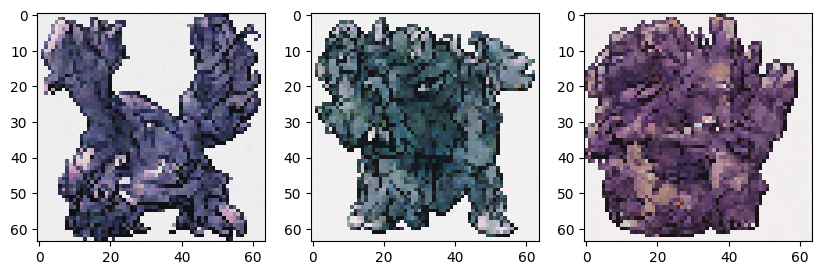

0.01875446:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 97999/100001 [2:20:59<02:50, 11.77it/s]

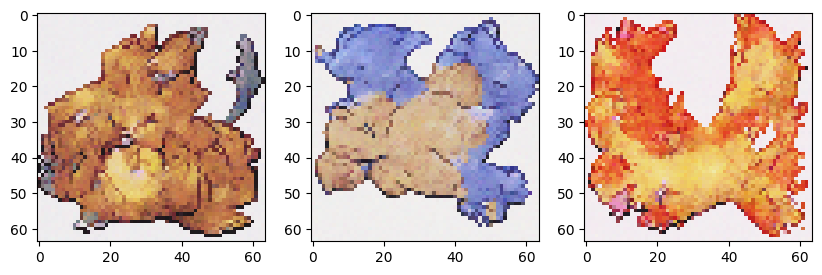

0.01135041:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 98999/100001 [2:22:25<01:24, 11.79it/s]

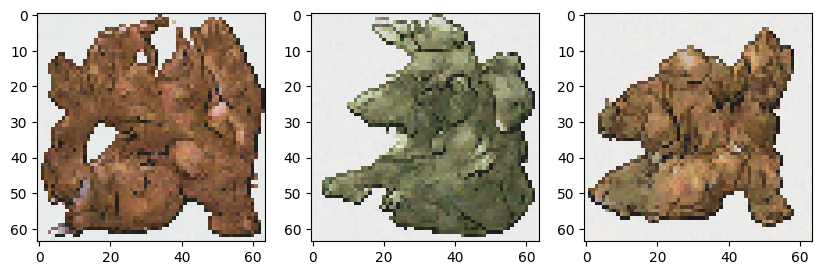

0.00659706: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 99999/100001 [2:23:51<00:00, 11.79it/s]

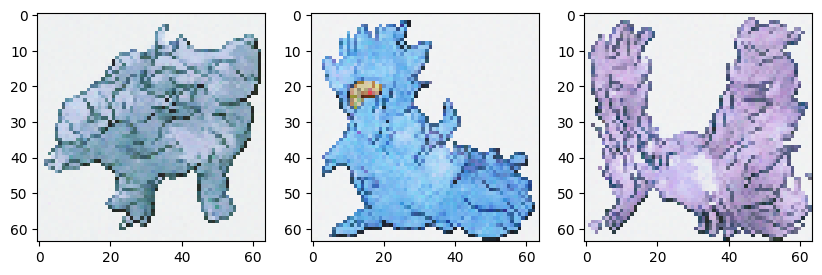

0.01744254: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100001/100001 [2:23:53<00:00, 11.58it/s]


In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')